# **Step 1: Load and Preprocess**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, monotonically_increasing_id
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler

# Step 1: Start Spark Session
spark = SparkSession.builder.appName("CUR_Buy_Sell").getOrCreate()

# Step 2: Load and clean data
path = "/content/drive/MyDrive/MMDS/Final/gold_prices.csv"
df = spark.read.option("header", True).option("inferSchema", True).csv(path)

In [2]:
# Format types
df = df.withColumn("Date", col("Date").cast("date"))
df = df.withColumn("Buy Price", col("Buy Price").cast(DoubleType()))
df = df.withColumn("Sell Price", col("Sell Price").cast(DoubleType()))
df = df.orderBy("Date")

# **Step 2: Generate Features and Labels**

In [3]:
# Step 3: Generate lag features from Buy Price
windowSpec = Window.orderBy("Date")
for i in range(1, 11):
    df = df.withColumn(f"lag_{i}", lag("Buy Price", i).over(windowSpec))

df = df.na.drop()

# Step 4: Assemble lag features
feature_cols = [f"lag_{i}" for i in range(10, 0, -1)]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Step 5: Prepare two labeled datasets
data_buy = df.select("Date", "features", col("Buy Price").alias("label_buy"))
data_sell = df.select("Date", "features", col("Sell Price").alias("label_sell"))

# Step 6: Add row index for ordered split
data_buy = data_buy.orderBy("Date").withColumn("row_id", monotonically_increasing_id())
data_sell = data_sell.orderBy("Date").withColumn("row_id", monotonically_increasing_id())

# Step 7: Time-based 70/30 split
total_count = data_buy.count()
train_count = int(total_count * 0.7)

train_df_buy = data_buy.filter(col("row_id") < train_count).select("features", col("label_buy").alias("label"))
test_df_buy = data_buy.filter(col("row_id") >= train_count).select("features", col("label_buy").alias("label"))

train_df_sell = data_sell.filter(col("row_id") < train_count).select("features", col("label_sell").alias("label"))
test_df_sell = data_sell.filter(col("row_id") >= train_count).select("features", col("label_sell").alias("label"))

# **Step 3: CURDecomposition Class**

In [4]:
import numpy as np
from pyspark.ml.linalg import Vectors, DenseMatrix
from pyspark.mllib.linalg.distributed import RowMatrix

class CURDecomposition:
    def __init__(self, k):
        self.k = k  # number of columns to retain

    def _to_row_matrix(self, df):
        return RowMatrix(df.rdd.map(lambda row: Vectors.dense(row["features"])))

    def fit_transform(self, df):
        # Step 1: Convert features to RowMatrix
        row_matrix = self._to_row_matrix(df)

        # Step 2: Compute column norms to form sampling probabilities
        num_cols = len(df.first()["features"])
        col_norms = [0.0] * num_cols
        for row in df.select("features").collect():
            vec = row["features"]
            for i in range(num_cols):
                col_norms[i] += vec[i] ** 2

        total_norm = sum(col_norms)
        probs = [n / total_norm for n in col_norms]

        # Step 3: Sample columns based on probabilities
        sampled_indices = np.random.choice(range(num_cols), size=self.k, replace=False, p=probs)
        sampled_indices.sort()

        # Step 4: Extract C matrix (selected columns from features)
        def extract_selected_cols(row):
            full_vec = row["features"]
            return Vectors.dense([full_vec[i] for i in sampled_indices])

        selected_df = df.rdd.map(lambda row: (extract_selected_cols(row), row["label"])).toDF(["features", "label"])

        return selected_df, sampled_indices

# **Step 4: Apply CUR Decomposition to your train and test sets**

In [5]:
# Initialize CUR with k = 5
cur = CURDecomposition(k=5)

# --- BUY PRICE CUR ---
train_reduced_buy_df, selected_indices_buy = cur.fit_transform(train_df_buy)

test_reduced_buy_df = test_df_buy.rdd.map(
    lambda row: (Vectors.dense([row["features"][i] for i in selected_indices_buy]), row["label"])
).toDF(["features", "label"])


# --- SELL PRICE CUR ---
train_reduced_sell_df, selected_indices_sell = cur.fit_transform(train_df_sell)

test_reduced_sell_df = test_df_sell.rdd.map(
    lambda row: (Vectors.dense([row["features"][i] for i in selected_indices_sell]), row["label"])
).toDF(["features", "label"])

# **Step 5: Train and Evaluate a Linear Regression Model on Reduced Data**

In [6]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

def evaluate_model(predictions):
    evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
    evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)

    return rmse, mae, r2

# --- CUR Model: Buy ---
lr_cur_buy = LinearRegression(featuresCol="features", labelCol="label")
model_cur_buy = lr_cur_buy.fit(train_reduced_buy_df)

pred_train_cur_buy = model_cur_buy.transform(train_reduced_buy_df)
pred_test_cur_buy = model_cur_buy.transform(test_reduced_buy_df)

rmse_train_cur_buy, mae_train_cur_buy, r2_train_cur_buy = evaluate_model(pred_train_cur_buy)
rmse_test_cur_buy, mae_test_cur_buy, r2_test_cur_buy = evaluate_model(pred_test_cur_buy)

# --- Original Model: Buy ---
lr_orig_buy = LinearRegression(featuresCol="features", labelCol="label")
model_orig_buy = lr_orig_buy.fit(train_df_buy)

pred_train_orig_buy = model_orig_buy.transform(train_df_buy)
pred_test_orig_buy = model_orig_buy.transform(test_df_buy)

rmse_train_orig_buy, mae_train_orig_buy, r2_train_orig_buy = evaluate_model(pred_train_orig_buy)
rmse_test_orig_buy, mae_test_orig_buy, r2_test_orig_buy = evaluate_model(pred_test_orig_buy)


# --- CUR Model: Sell ---
lr_cur_sell = LinearRegression(featuresCol="features", labelCol="label")
model_cur_sell = lr_cur_sell.fit(train_reduced_sell_df)

pred_train_cur_sell = model_cur_sell.transform(train_reduced_sell_df)
pred_test_cur_sell = model_cur_sell.transform(test_reduced_sell_df)

rmse_train_cur_sell, mae_train_cur_sell, r2_train_cur_sell = evaluate_model(pred_train_cur_sell)
rmse_test_cur_sell, mae_test_cur_sell, r2_test_cur_sell = evaluate_model(pred_test_cur_sell)

# --- Original Model: Sell ---
lr_orig_sell = LinearRegression(featuresCol="features", labelCol="label")
model_orig_sell = lr_orig_sell.fit(train_df_sell)

pred_train_orig_sell = model_orig_sell.transform(train_df_sell)
pred_test_orig_sell = model_orig_sell.transform(test_df_sell)

rmse_train_orig_sell, mae_train_orig_sell, r2_train_orig_sell = evaluate_model(pred_train_orig_sell)
rmse_test_orig_sell, mae_test_orig_sell, r2_test_orig_sell = evaluate_model(pred_test_orig_sell)


In [7]:
# --- BUY PRICE ---
print("BUY - Train (Original):")
print(f"  RMSE: {rmse_train_orig_buy:.4f}")
print(f"  MAE : {mae_train_orig_buy:.4f}")
print(f"  R²  : {r2_train_orig_buy:.4f}\n")

print("BUY - Train (CUR):")
print(f"  RMSE: {rmse_train_cur_buy:.4f}")
print(f"  MAE : {mae_train_cur_buy:.4f}")
print(f"  R²  : {r2_train_cur_buy:.4f}\n")

print("BUY - Test (Original):")
print(f"  RMSE: {rmse_test_orig_buy:.4f}")
print(f"  MAE : {mae_test_orig_buy:.4f}")
print(f"  R²  : {r2_test_orig_buy:.4f}\n")

print("BUY - Test (CUR):")
print(f"  RMSE: {rmse_test_cur_buy:.4f}")
print(f"  MAE : {mae_test_cur_buy:.4f}")
print(f"  R²  : {r2_test_cur_buy:.4f}\n")


# --- SELL PRICE ---
print("SELL - Train (Original):")
print(f"  RMSE: {rmse_train_orig_sell:.4f}")
print(f"  MAE : {mae_train_orig_sell:.4f}")
print(f"  R²  : {r2_train_orig_sell:.4f}\n")

print("SELL - Train (CUR):")
print(f"  RMSE: {rmse_train_cur_sell:.4f}")
print(f"  MAE : {mae_train_cur_sell:.4f}")
print(f"  R²  : {r2_train_cur_sell:.4f}\n")

print("SELL - Test (Original):")
print(f"  RMSE: {rmse_test_orig_sell:.4f}")
print(f"  MAE : {mae_test_orig_sell:.4f}")
print(f"  R²  : {r2_test_orig_sell:.4f}\n")

print("SELL - Test (CUR):")
print(f"  RMSE: {rmse_test_cur_sell:.4f}")
print(f"  MAE : {mae_test_cur_sell:.4f}")
print(f"  R²  : {r2_test_cur_sell:.4f}")

BUY - Train (Original):
  RMSE: 0.2114
  MAE : 0.1069
  R²  : 0.9983

BUY - Train (CUR):
  RMSE: 0.2985
  MAE : 0.1643
  R²  : 0.9966

BUY - Test (Original):
  RMSE: 0.4672
  MAE : 0.2222
  R²  : 0.9977

BUY - Test (CUR):
  RMSE: 0.6777
  MAE : 0.3518
  R²  : 0.9951

SELL - Train (Original):
  RMSE: 0.2503
  MAE : 0.1481
  R²  : 0.9977

SELL - Train (CUR):
  RMSE: 0.2507
  MAE : 0.1481
  R²  : 0.9977

SELL - Test (Original):
  RMSE: 0.9097
  MAE : 0.6031
  R²  : 0.9921

SELL - Test (CUR):
  RMSE: 0.9100
  MAE : 0.6035
  R²  : 0.9921


# **Step 6: Visualize and compare the metrics**

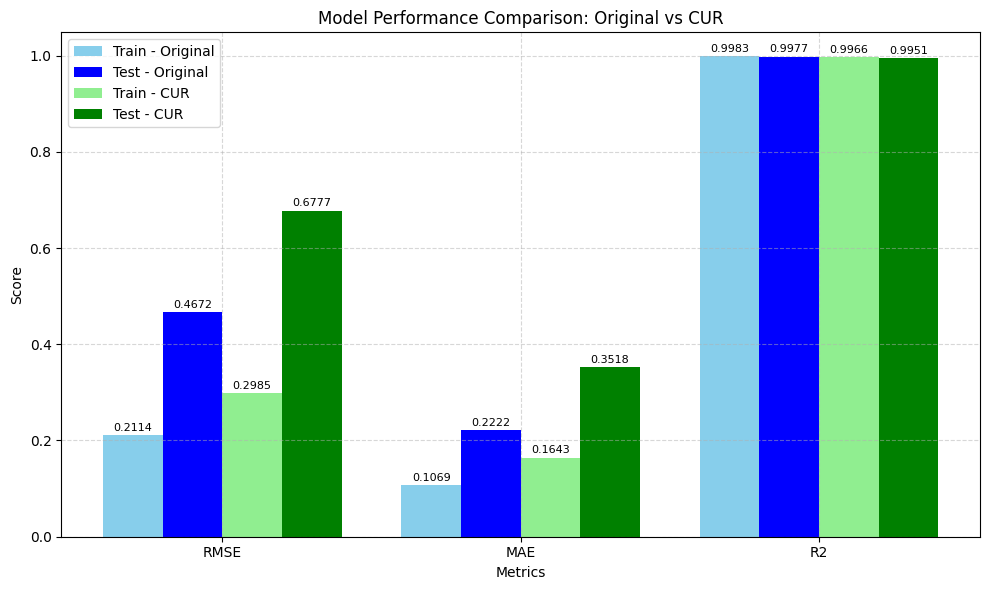

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['RMSE', 'MAE', 'R2']
train_orig_buy = [rmse_train_orig_buy, mae_train_orig_buy, r2_train_orig_buy]
test_orig_buy  = [rmse_test_orig_buy,  mae_test_orig_buy,  r2_test_orig_buy]
train_cur_buy  = [rmse_train_cur_buy,  mae_train_cur_buy,  r2_train_cur_buy]
test_cur_buy   = [rmse_test_cur_buy,   mae_test_cur_buy,   r2_test_cur_buy]

# X axis positions
x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# Bars
bars1 = ax.bar(x - 1.5*width, train_orig_buy, width, label='Train - Original', color='skyblue')
bars2 = ax.bar(x - 0.5*width, test_orig_buy, width, label='Test - Original', color='blue')
bars3 = ax.bar(x + 0.5*width, train_cur_buy,  width, label='Train - CUR', color='lightgreen')
bars4 = ax.bar(x + 1.5*width, test_cur_buy,  width, label='Test - CUR', color='green')

# Axes
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison: Original vs CUR (Buy)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# .4f value labels
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

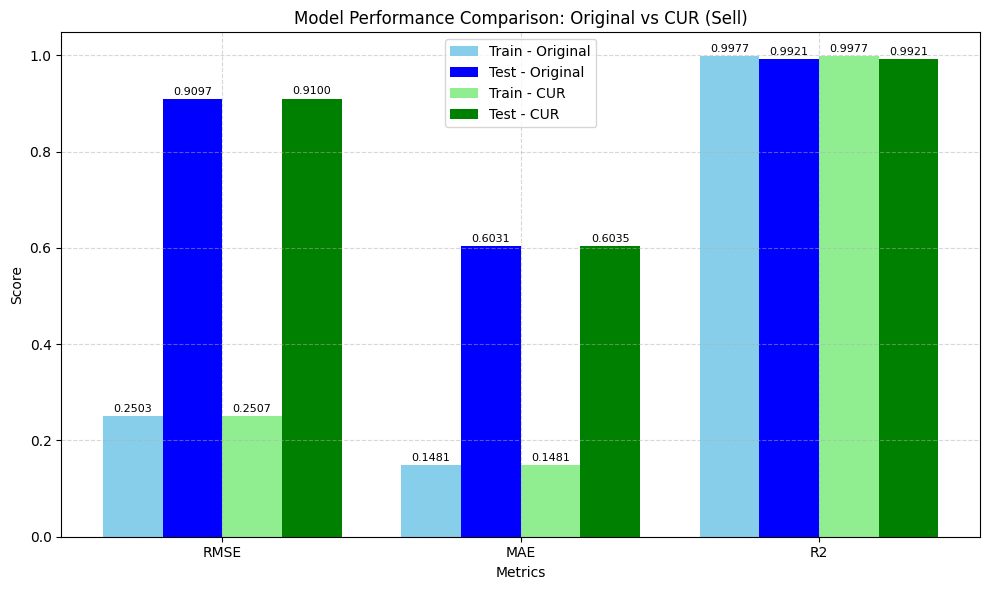

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['RMSE', 'MAE', 'R2']
train_orig_sell = [rmse_train_orig_sell, mae_train_orig_sell, r2_train_orig_sell]
test_orig_sell  = [rmse_test_orig_sell,  mae_test_orig_sell,  r2_test_orig_sell]
train_cur_sell  = [rmse_train_cur_sell,  mae_train_cur_sell,  r2_train_cur_sell]
test_cur_sell   = [rmse_test_cur_sell,   mae_test_cur_sell,   r2_test_cur_sell]

# X axis positions
x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# Bars
bars1 = ax.bar(x - 1.5*width, train_orig_sell, width, label='Train - Original', color='skyblue')
bars2 = ax.bar(x - 0.5*width, test_orig_sell, width, label='Test - Original', color='blue')
bars3 = ax.bar(x + 0.5*width, train_cur_sell,  width, label='Train - CUR', color='lightgreen')
bars4 = ax.bar(x + 1.5*width, test_cur_sell,  width, label='Test - CUR', color='green')

# Axes
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison: Original vs CUR (Sell)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# .4f value labels
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

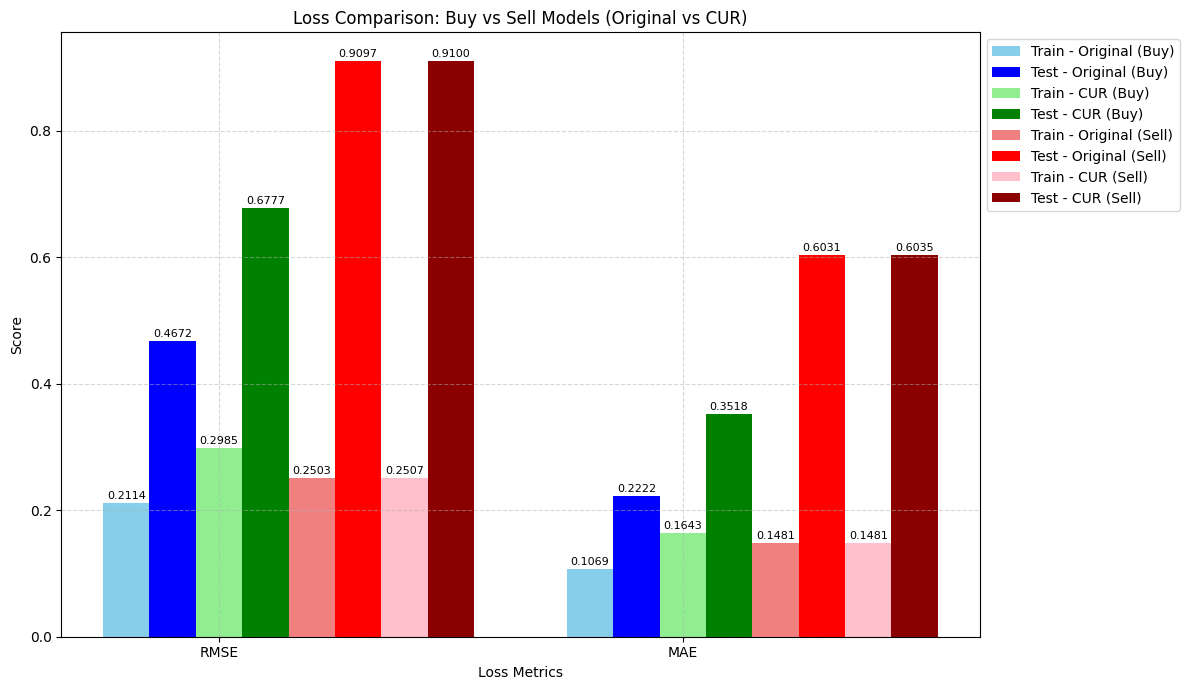

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics - focusing only on loss metrics
metrics = ['RMSE', 'MAE']

# Buy losses
train_orig_buy = [rmse_train_orig_buy, mae_train_orig_buy]
test_orig_buy  = [rmse_test_orig_buy,  mae_test_orig_buy]
train_cur_buy  = [rmse_train_cur_buy,  mae_train_cur_buy]
test_cur_buy   = [rmse_test_cur_buy,   mae_test_cur_buy]

# Sell losses
train_orig_sell = [rmse_train_orig_sell, mae_train_orig_sell]
test_orig_sell  = [rmse_test_orig_sell,  mae_test_orig_sell]
train_cur_sell  = [rmse_train_cur_sell,  mae_train_cur_sell]
test_cur_sell   = [rmse_test_cur_sell,   mae_test_cur_sell]

x = np.arange(len(metrics))
width = 0.1

fig, ax = plt.subplots(figsize=(12, 7))

# Plot Buy bars
bars1 = ax.bar(x - 2*width, train_orig_buy, width, label='Train - Original (Buy)', color='skyblue')
bars2 = ax.bar(x - width,   test_orig_buy,  width, label='Test - Original (Buy)',  color='blue')
bars3 = ax.bar(x,           train_cur_buy,  width, label='Train - CUR (Buy)',      color='lightgreen')
bars4 = ax.bar(x + width,   test_cur_buy,   width, label='Test - CUR (Buy)',       color='green')

# Plot Sell bars
bars5 = ax.bar(x + 2*width, train_orig_sell, width, label='Train - Original (Sell)', color='lightcoral')
bars6 = ax.bar(x + 3*width, test_orig_sell,  width, label='Test - Original (Sell)',  color='red')
bars7 = ax.bar(x + 4*width, train_cur_sell,  width, label='Train - CUR (Sell)',      color='pink')
bars8 = ax.bar(x + 5*width, test_cur_sell,   width, label='Test - CUR (Sell)',       color='darkred')

# Axes and labels
ax.set_xlabel('Loss Metrics')
ax.set_ylabel('Score')
ax.set_title('Loss Comparison: Buy vs Sell Models (Original vs CUR)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.grid(True, linestyle='--', alpha=0.5)

# Annotate bars with values
for bars in [bars1, bars2, bars3, bars4, bars5, bars6, bars7, bars8]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

plt.tight_layout()
plt.show()